<a href="https://colab.research.google.com/github/nikeshthapa255/AI-MLOPS/blob/main/M1_NB_MiniProject_2_Structured_Data_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Mini-Project Notebook: Structured Data Classification

## Problem Statement

To predict whether a patient has a heart disease.

## Learning Objectives

At the end of the experiment, you will be able to

* Understand the Cleveland Clinic Foundation Heart Disease dataset
* Pre-process this dataset using Keras layers: IntegerLookup, StringLookup & Normalization
* Understand and use Keras concatenate layer
* Build a neural network model and architecture using Keras functional api
* Predict an unseen data

## Introduction

This example demonstrates how to do structured data classification, starting from a raw
CSV file. Our data includes both numerical and categorical features. We will use Keras
preprocessing layers to normalize the numerical features and vectorize the categorical
ones.

Note that this example should be run with TensorFlow 2.5 or higher.

## Dataset

[Our dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) is provided by the
Cleveland Clinic Foundation for Heart Disease.
It's a CSV file with 303 rows. Each row contains information about a patient (a
**sample**), and each column describes an attribute of the patient (a **feature**). We
use the features to predict whether a patient has a heart disease (**binary
classification**).

Here's the description of each feature:
<br><br>

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | 3 = normal; 6 = fixed defect; 7 = reversible defect | Categorical
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

<br><br>

In [1]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/AIandMLOps/Datasets/heart.csv
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


## Grading = 10 Points

### Import Required Packages

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import IntegerLookup     # Used in Feature processing
from tensorflow.keras.layers import Normalization     # Used in Feature processing
from tensorflow.keras.layers import StringLookup      # Used in Feature processing

# Part A

## Load the data and create batches [2 Marks]

### Load data into a Pandas dataframe

Hint:: pd.read_csv

In [3]:
file_url = "/content/heart.csv"
df = pd.read_csv(file_url)

Check the shape of the dataset:

In [4]:
df.shape

(303, 14)

Check the preview of a few samples:

Hint:: head()

In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


Draw some inference from the data. What does the target column indicate?

The last column, "target", indicates whether the patient has a heart disease (1) or not
(0).

### Split the data into a training and validation set

Hint:: Use .sample() method from Pandas.

Refer to link [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html)

Official reference from pandas for drop method [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html)

In [6]:
train_dataframe = df.sample(frac=0.8, random_state=1)
val_dataframe = df.drop(train_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 242 samples for training and 61 for validation


### Converting into tensorflow dataset & creating batches

Generate `tf.data.Dataset` objects for each dataframe:

Each `Dataset` yields a tuple `(input, target)` where `input` is a dictionary of features
and `target` is the value `0` or `1`:

Refer [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices) to create the tuple using tensorflow.

In [7]:
TARGET_FIELDNAME = 'target'

def dataframe_to_dataset(dataframe):
    input, target = dataframe.drop([TARGET_FIELDNAME], axis=1), dataframe[TARGET_FIELDNAME]
    # Convert the Pandas dataframe to a TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((dict(input), target))
    return dataset

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [8]:
# Visualizing one datapoint from the formatted data
## YOUR CODE HERE
# Get one sample (a batch of size 1) from the training dataset
def view_one_data(dataset):
    for features, label in dataset.take(1):
        # Features are in dictionary format
        print("Features:")
        for key, value in features.items():
            print(f"  {key}: {value}")
        print("Label:", label)
view_one_data(train_ds)

Features:
  age: 76
  sex: 0
  cp: 3
  trestbps: 140
  chol: 197
  fbs: 0
  restecg: 1
  thalach: 116
  exang: 0
  oldpeak: 1.1
  slope: 2
  ca: 0
  thal: b'normal'
Label: tf.Tensor(0, shape=(), dtype=int64)


#### Create the batch of the datasets:

Refer [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) to create a batch using tensorflow.

In [9]:
BATCH_SIZE = 16
def create_batch(dataset):
    return dataset.batch(BATCH_SIZE)
## YOUR CODE HERE  ## For train
train_ds_batch = create_batch(train_ds)
## YOUR CODE HERE  ## For val
val_ds_batch = create_batch(val_ds)

## Feature preprocessing with Keras layers [3 Marks]

### Categorical Features Encoding

**The** following features are categorical features encoded as integers:

- `sex`
- `cp`
- `fbs`
- `restecg`
- `exang`
- `ca`

In [10]:
# feature = train_ds_batch.take(1)
view_one_data(train_ds_batch)


Features:
  age: [76 41 71 67 46 39 41 53 58 50 45 45 60 35 58 63]
  sex: [0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0]
  cp: [3 3 4 3 4 4 4 4 4 4 4 3 3 2 2 4]
  trestbps: [140 130 112 152 120 118 110 142 100 144 104 110 140 122 136 150]
  chol: [197 214 149 277 249 219 172 226 234 200 208 264 185 192 319 407]
  fbs: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
  restecg: [1 2 0 0 2 0 2 2 0 2 2 1 2 0 2 2]
  thalach: [116 168 125 172 144 140 158 111 156 126 148 132 155 174 152 154]
  exang: [0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0]
  oldpeak: [1.1 2.  1.6 0.  0.8 1.2 0.  0.  0.1 0.9 3.  1.2 3.  0.  0.  4. ]
  slope: [2 2 2 1 1 2 1 1 1 2 2 1 2 1 1 2]
  ca: [0 0 0 1 0 0 0 0 1 0 0 0 0 0 2 3]
  thal: [b'normal' b'normal' b'normal' b'normal' b'reversible' b'reversible'
 b'reversible' b'reversible' b'reversible' b'reversible' b'normal'
 b'normal' b'normal' b'normal' b'normal' b'reversible']
Label: tf.Tensor([0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1], shape=(16,), dtype=int64)


We will encode these features using **one-hot encoding**. We have two options
here:

 - Use `CategoryEncoding()`, which requires knowing the range of input values
 and will throw an error on input outside the range.
 - Use `IntegerLookup()` which will build a lookup table for inputs and **reserve
 an output index for unkown input values**.

For this example, we want a simple solution that will handle out of range inputs
at inference, so we will use `IntegerLookup()`.

We also have a categorical feature encoded as a string: `thal`. We will create an
index of all possible features and encode output using the `StringLookup()` layer.

Create a function `encode_categorical_feature`, this function takes four parameters.
1. Feature to be encoded.
2. Name of the feature in the dataset.
3. Dataset containing the feature.
4. A boolean value wether the feature is string or not.

**Refer :** StringLookup [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup) and IntegerLookup [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/IntegerLookup).

In [11]:
def encode_categorical_feature(feature, name, dataset, is_string):
    # Check if the feature is string type
    if is_string:
        # Create a StringLookup layer to map strings to integer indices
        lookup = tf.keras.layers.StringLookup(output_mode='int')
    else:
        # Create an IntegerLookup layer to map integers to integer indices
        lookup = tf.keras.layers.IntegerLookup(output_mode='int')

    # Prepare a Dataset that only yields our feature
    feature_dataset = dataset.map(lambda x, y: x[name])

    # Adapt the lookup layer to the dataset
    lookup.adapt(feature_dataset)

    # Encode the feature by turning the input into integer indices
    encoded_feature = lookup(feature)

    return encoded_feature


### Numerical features Normalization
The following feature are continuous numerical features:

- `age`
- `trestbps`
- `chol`
- `thalach`
- `oldpeak`
- `slope`

For each of these features, we will use a `Normalization()` layer to make sure the mean
of each feature is 0 and its standard deviation is 1.


- Define a function `encode_numerical_feature` to apply featurewise normalization to numerical features.


Refer Normalization [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization)

In [12]:
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = tf.keras.layers.Normalization(axis=None)

    # Prepare a Dataset that only yields our feature
    feature_dataset = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data
    normalizer.adapt(feature_dataset)

    # Normalize the input feature
    encoded_feature = normalizer(feature)

    # Cast the normalized feature to integer type
    encoded_feature = tf.cast(encoded_feature, tf.int64)

    return encoded_feature

# Part B

## Building the model [4 Marks]

#### Need to instantiate a Keras tensor for all features
 Use keras Input() [method](https://keras.io/api/layers/core_layers/input/).
* Create a list of inputs to be fed to the model.
* This list consists of the features output from keras Input() method.
* These inputs include all the features.


In [13]:
# Categorical features encoded as integers
sex = tf.keras.Input(shape=(1,), name='sex', dtype='int32')
cp = tf.keras.Input(shape=(1,), name='cp', dtype='int32')
fbs = tf.keras.Input(shape=(1,), name='fbs', dtype='int32')
restecg = tf.keras.Input(shape=(1,), name='restecg', dtype='int32')
exang = tf.keras.Input(shape=(1,), name='exang', dtype='int32')
ca = tf.keras.Input(shape=(1,), name='ca', dtype='int32')

# Categorical feature encoded as string
thal = tf.keras.Input(shape=(1,), name='thal', dtype='string')

# Numerical features
age = tf.keras.Input(shape=(1,), name='age', dtype='float32')
trestbps = tf.keras.Input(shape=(1,), name='trestbps', dtype='float32')
chol = tf.keras.Input(shape=(1,), name='chol', dtype='float32')
thalach = tf.keras.Input(shape=(1,), name='thalach', dtype='float32')
oldpeak = tf.keras.Input(shape=(1,), name='oldpeak', dtype='float32')
slope = tf.keras.Input(shape=(1,), name='slope', dtype='float32')

all_inputs = [sex, cp, fbs, restecg,exang,ca,thal,age,trestbps,chol,thalach,oldpeak,slope]
## These list of inputs objects are fed inside the model as inputs

### Encoding above features
Use  "encode_categorical_feature" & "encode_numerical_feature" function on respective features that we defined above.

In [14]:
# Integer categorical features
sex_encoded = encode_categorical_feature(sex, 'sex', train_ds, False)
cp_encoded = encode_categorical_feature(cp, 'cp', train_ds, False)
fbs_encoded = encode_categorical_feature(fbs, 'fbs', train_ds, False)
restecg_encoded = encode_categorical_feature(restecg, 'restecg', train_ds, False)
exang_encoded = encode_categorical_feature(exang, 'exang', train_ds, False)
ca_encoded = encode_categorical_feature(ca, 'ca', train_ds, False)

# String categorical features
thal_encoded = encode_categorical_feature(thal, 'thal', train_ds, True)

# Numerical features
age_encoded = encode_numerical_feature(age,'age',train_ds)
trestbps_encoded = encode_numerical_feature(trestbps,'trestbps',train_ds)
chol_encoded = encode_numerical_feature(chol,'chol',train_ds)
thalach_encoded = encode_numerical_feature(thalach,'thalach',train_ds)
oldpeak_encoded = encode_numerical_feature(oldpeak,'oldpeak',train_ds)
slope_encoded = encode_numerical_feature(slope,'slope',train_ds)

##### Understanding the result of  encoder functions

In [15]:
def view_encoded_feature(input, name, encoded, ds_batch):
    # Create the TensorFlow model
    model = tf.keras.Model(inputs=input, outputs=encoded)

    # To predict, we need to convert DataFrame column to TensorFlow tensor
    sex_data = tf.convert_to_tensor(df[name].values, dtype=tf.int32)

    for batch in ds_batch.take(1):  # Just taking one batch for demonstration
        inputs, targets = batch
        output = model.predict(inputs[name])
        print(output)

view_encoded_feature(sex, 'sex', sex_encoded, train_ds_batch)

sex_encoded

1/1 [==============================] - 0s 133ms/step
[[2]
 [1]
 [2]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]]


<KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'integer_lookup')>

In [16]:
# cp_encoded = ## YOUR CODE HERE
print(cp_encoded.get_shape())

# view_encoded_feature(cp, 'cp', cp_encoded, train_ds_batch)

(None, 1)


### Using Functional API for building model
Build the three model architectures with 1, 2, and 3 hidden layers having different numbers of neurons. Train for each architecture and compare the train and the validation accuracy.

* These inputs will be passed to keras.model.
* Concatenate the encoded features using layers.concatenate()
* Add the Dense layers and compile the model.

In [17]:
all_inputs = [sex, cp, fbs, restecg,exang,ca,thal,age,trestbps,chol,thalach,oldpeak,slope]

# Example: Assuming each input feature is already encoded and stored in variables like 'encoded_sex', 'encoded_cp', etc.
all_encoded_features = [
    sex_encoded, cp_encoded, fbs_encoded, restecg_encoded, exang_encoded, ca_encoded,
    thal_encoded, age_encoded, trestbps_encoded, chol_encoded, thalach_encoded, oldpeak_encoded, slope_encoded
]

# Concatenate all encoded inputs
all_features = layers.concatenate(all_encoded_features)

# Adding Dense layers with Dropout
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.3)(x)

# Output layer - adjust according to your specific problem, e.g., binary classification here
output = layers.Dense(1, activation="sigmoid")(x)

# Create the model
model = keras.Model(inputs=all_inputs, outputs=output)


# Configure the optimizer with a specific learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.005)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


### Visualize the connectivity graph using `keras.utils.plot_model`:

In [18]:
from tensorflow.keras.utils import plot_model

# `rankdir='LR'` is to make the graph horizontal.
plot_model(model, rankdir='LR')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Train the model

(Change the Colab notebook's runtime to GPU for faster training)

In [19]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
callbacks_list = [EarlyStopping(monitor="val_loss", patience=10),
                  ModelCheckpoint("mnist_model_checkpoint", save_best_only=True),
                  TensorBoard(log_dir="./tensorboard_files")
                  ]

# Training the model
history = model.fit(
    train_ds_batch,
    epochs=100,
    validation_data=val_ds_batch,
    callbacks= callbacks_list
)

Epoch 1/100
16/16 [==============================] - 4s 189ms/step - loss: 0.6096 - accuracy: 0.7107 - val_loss: 0.5870 - val_accuracy: 0.7049
Epoch 2/100
16/16 [==============================] - 2s 121ms/step - loss: 0.5085 - accuracy: 0.7355 - val_loss: 0.5279 - val_accuracy: 0.7049
Epoch 3/100
16/16 [==============================] - 2s 144ms/step - loss: 0.5030 - accuracy: 0.7397 - val_loss: 0.5042 - val_accuracy: 0.7049
Epoch 4/100
16/16 [==============================] - 2s 121ms/step - loss: 0.4773 - accuracy: 0.7273 - val_loss: 0.4499 - val_accuracy: 0.7541
Epoch 5/100
16/16 [==============================] - 2s 121ms/step - loss: 0.4320 - accuracy: 0.7934 - val_loss: 0.4043 - val_accuracy: 0.8197
Epoch 6/100
16/16 [==============================] - 2s 147ms/step - loss: 0.3812 - accuracy: 0.7975 - val_loss: 0.3613 - val_accuracy: 0.7705
Epoch 7/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4316 - accuracy: 0.8264 - val_loss: 0.3744 - val_accuracy: 0.8361
E

## Inference on new data [1 Mark]

To get a prediction for a new sample, you can simply call `model.predict()`. There are
just two things you need to do:

1. wrap scalars into a list so as to have a batch dimension (models only process batches
of data, not single samples)
2. Call `convert_to_tensor` on each feature

Note : The predicted output should be either 0  or 1 based on a threshold value of probability 0.5.

In [21]:
sample = {
    "age": 63,
    "sex": 2,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
    "target": 0
}
label = sample['target']  # Ensure 'target' is the column name for labels in your DataFrame

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

predicted_label = 1 if predictions > 0.5 else 0  # Adjust based on your model's output structure

# Print the predicted label and the true label
print(f"Predicted: {predicted_label}, Actual: {label}")


1/1 [==============================] - 0s 202ms/step
Predicted: 0, Actual: 0


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


## Hyperparameter tuning
**Keras tuner**

In [22]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.6 MB/s eta 0:00:00


In [23]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers

def build_model(hp):
    all_encoded_features = [
    sex_encoded, cp_encoded, fbs_encoded, restecg_encoded, exang_encoded, ca_encoded,
    thal_encoded, age_encoded, trestbps_encoded, chol_encoded, thalach_encoded, oldpeak_encoded, slope_encoded]

    # Concatenate all encoded inputs
    all_features = layers.concatenate(all_encoded_features)

    # Hyperparameters for the number of units and dropout in each Dense layer
    x = all_features
    for i in range(hp.Int('num_layers', 2, 5)):  # Tuning the number of layers between 2 and 5
        x = layers.Dense(
            units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
            activation='relu'
        )(x)
        x = layers.Dropout(
            rate=hp.Float('dropout_' + str(i), min_value=0.2, max_value=0.5, step=0.1)
        )(x)

    # Output layer for binary classification
    output = layers.Dense(1, activation='sigmoid')(x)

    # Create and compile the model
    model = keras.Model(inputs=all_inputs, outputs=output)
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [24]:
# Create a tuner. You can choose among RandomSearch, Hyperband, BayesianOptimization, etc.
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt'
)

# Early stopping callback to prevent overfitting
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [25]:
# Assuming train_ds and val_ds are your training and validation datasets
tuner.search(train_ds_batch, validation_data=val_ds_batch, epochs=50, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best number of layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"Best units in layer {i}: {best_hps.get('units_' + str(i))}")
    print(f"Best dropout in layer {i}: {best_hps.get('dropout_' + str(i))}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")


Trial 30 Complete [00h 00m 03s]
val_accuracy: 0.8524590134620667

Best val_accuracy So Far: 0.8524590134620667
Total elapsed time: 00h 01m 13s
Best number of layers: 3
Best units in layer 0: 320
Best dropout in layer 0: 0.4
Best units in layer 1: 256
Best dropout in layer 1: 0.30000000000000004
Best units in layer 2: 32
Best dropout in layer 2: 0.4
Best learning rate: 0.0013448774790511659


In [26]:
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
loss, accuracy = best_model.evaluate(val_ds_batch)
print(f"Best model accuracy: {accuracy}")


4/4 [==============================] - 0s 4ms/step - loss: 0.3423 - accuracy: 0.8525
Best model accuracy: 0.8524590134620667


In [30]:
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 age (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 trestbps (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 chol (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 thalach (InputLayer)        [(None, 1)]                  0         []                            
                                                                                              

In [27]:
MODEL_PATH = 'best_model'

In [28]:
# Save the best model
# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Save the best model
best_model.save(MODEL_PATH)  # Save to HDF5 or SavedModel format (TF 2.x+ default)


In [29]:
# Load model
from tensorflow import keras

# Load the previously saved model
loaded_model = keras.models.load_model(MODEL_PATH)

# Now, `loaded_model` is ready to be used for predictions or evaluation


### Analyse the model

#### Confusion Matrix

4/4 [==============================] - 0s 3ms/step


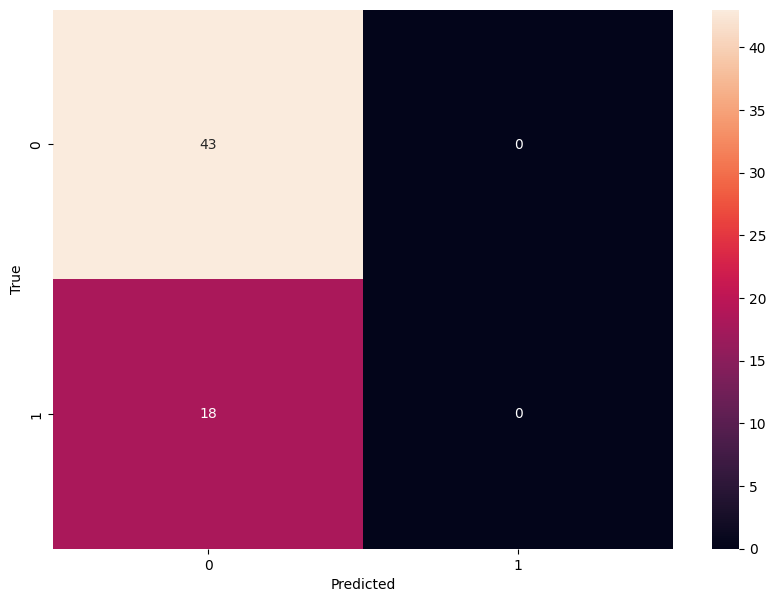

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predict classes with the best model
y_pred = np.argmax(best_model.predict(val_ds_batch), axis=1)
y_true = np.concatenate([y for x, y in val_ds_batch], axis=0)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


#### Classification Report

In [32]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.70      1.00      0.83        43
           1       0.00      0.00      0.00        18

    accuracy                           0.70        61
   macro avg       0.35      0.50      0.41        61
weighted avg       0.50      0.70      0.58        61



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### ROC AND AUC Curve

4/4 [==============================] - 0s 2ms/step


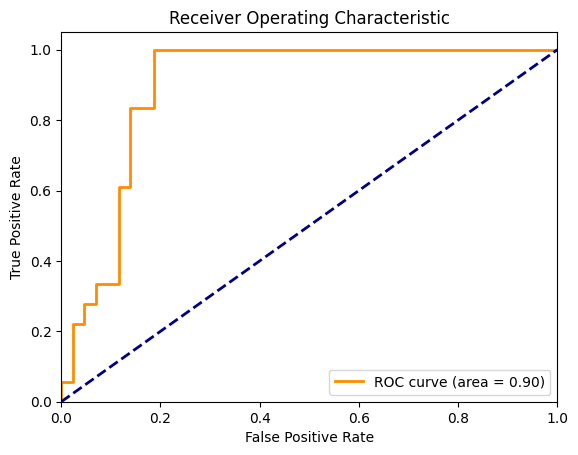

In [33]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true, best_model.predict(val_ds_batch).ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#### Learning Curve

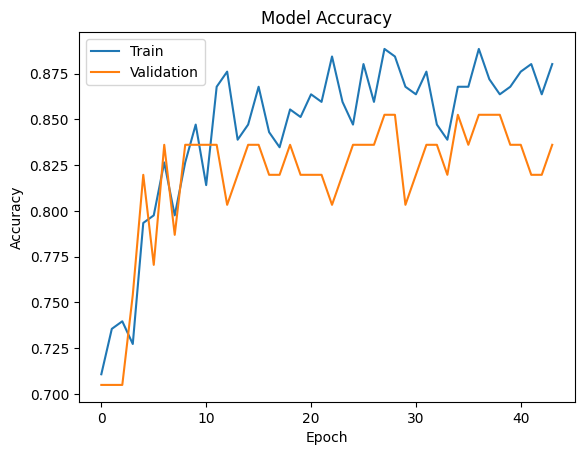

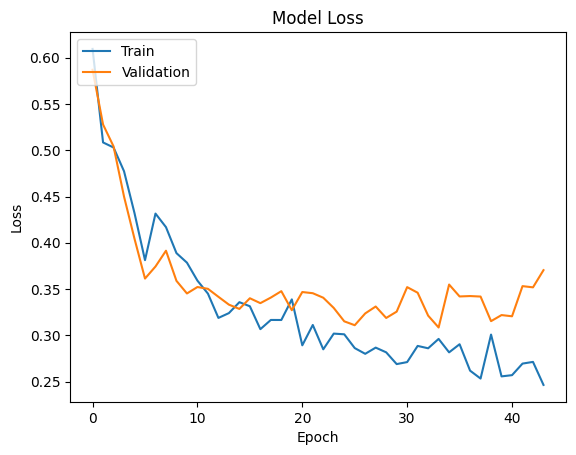

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
